# Investigating the KNN algorithm as an alternative classifier

In [1]:
import torch
import pandas as pd
import os
from torchvision.io import read_image
from torchvision.transforms import v2
from torch.utils.data import Dataset

bean_annotations = pd.read_csv("../data/beans.csv")
bean_annotations.head()
DEFECT_CLASSES = dict(
    [
        (defect, index)
        for (index, defect) in enumerate(pd.unique(bean_annotations["defect_class"]))
    ]
)


transform = v2.Compose(
    [
        v2.Resize(size=(400, 400)),
        v2.ToDtype(
            torch.float32, scale=True
        ),  # Use float32 datatype to enable training on Apple silicon GPU
        # v2.Grayscale(),
        # v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
    ]
)

In [2]:
class RoastDefectsDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        self.bean_annotations = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.bean_annotations)

    def get_labels(self):
        return self.bean_annotations["defect_class"]

    def __getitem__(self, item):
        if torch.is_tensor(item):
            item = item.toList()

        img_name = self.bean_annotations.iloc[item, 0]
        img_dir = "-".join(img_name.split("-")[0:4])
        img_path = os.path.join(self.root_dir, img_dir, img_name)
        image = read_image(img_path)

        if self.transform:
            image = self.transform(image)

        annotations = DEFECT_CLASSES[
            self.bean_annotations.iloc[item, 1:]["defect_class"]
        ]
        return image, annotations

In [3]:
from sklearn.model_selection import train_test_split

train, test = train_test_split(
    bean_annotations,
    test_size=0.2,
    random_state=42,  # for repeatability
    stratify=bean_annotations["defect_class"],
)

In [44]:
from torch.utils.data import DataLoader, SubsetRandomSampler

dataset = RoastDefectsDataset(
    csv_file="../data/beans.csv",
    root_dir="../data/processed",
    transform=transform,
)

train_sampler = SubsetRandomSampler(list(train.index))
test_sampler = SubsetRandomSampler(list(test.index))


train_loader = DataLoader(dataset, sampler=train_sampler, batch_size=len(train))
test_loader = DataLoader(dataset, sampler=test_sampler, batch_size=len(test))

dataloaders = {"test": test_loader, "train": train_loader}
dataset_sizes = {"test": len(test), "train": len(train)}

## Build datasets

In [5]:
X_train = []
y_train = []
X_test = []
y_test = []
for _, (data, label) in enumerate(train_loader):
    X_train = data.squeeze()
    y_train = label.squeeze()

for _, (data, label) in enumerate(test_loader):
    X_test = data.squeeze()
    y_test = label.squeeze()

## Dimensionality reduction - color histograms

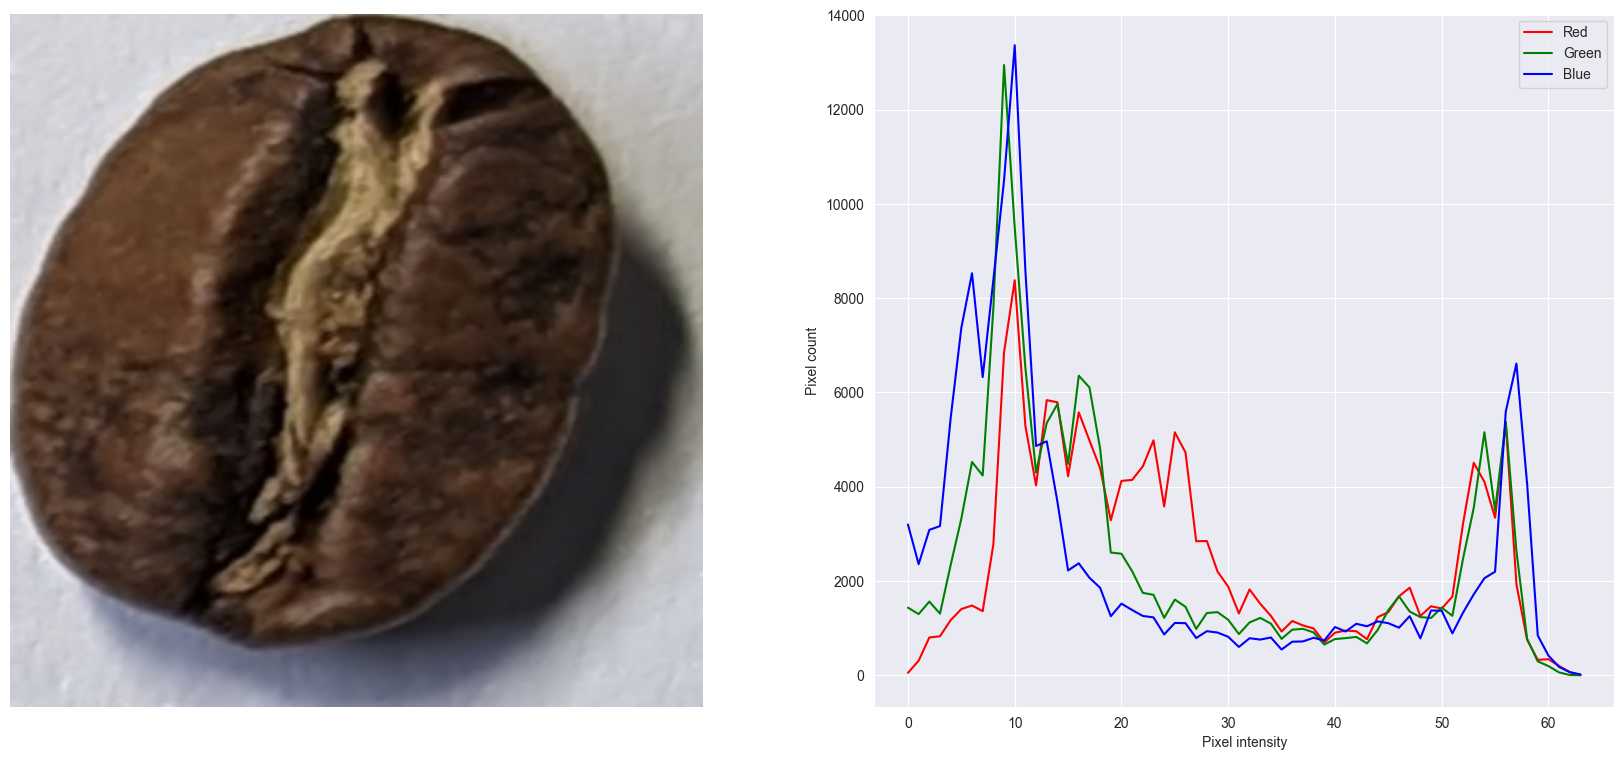

In [71]:
from skimage.exposure import histogram
from matplotlib import pyplot as plt

fig, (img_plot, hist_plot) = plt.subplots(1, 2, figsize=(21, 9))
sample_image = dataset[686][0]
hist, bins = histogram(sample_image.numpy(), nbins=64, channel_axis=0)
for index, channel in enumerate(hist):
    hist_plot.plot(
        channel,
        c=["red", "green", "blue"][index],
        label=["Red", "Green", "Blue"][index],
    )
hist_plot.legend()
hist_plot.set_xlabel("Pixel intensity")
hist_plot.set_ylabel("Pixel count")
img_plot.imshow(sample_image.permute(2, 1, 0))
img_plot.axis("off")
plt.savefig("../report/figures/methodology/histogramExample.png", bbox_inches="tight")

In [27]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import classification_report

for bin_count in [32, 64, 128, 256]:
    X_train_hists = [
        histogram(img.numpy(), nbins=bin_count, channel_axis=0)[0].ravel()
        for img in X_train
    ]
    X_test_hists = [
        histogram(img.numpy(), nbins=bin_count, channel_axis=0)[0].ravel()
        for img in X_test
    ]
    for metric in ["manhattan", "canberra", "euclidean"]:
        for k in range(1, 30):
            knn = KNeighborsClassifier(n_neighbors=k, metric=metric)
            knn.fit(X_train_hists, y_train)
            preds = knn.predict(X_test_hists)

            print(
                "Metric - ",
                metric,
                "K = ",
                k,
                "Bins - ",
                bin_count,
                "accuracy: ",
                classification_report(
                    y_test,
                    preds,
                    zero_division=0,
                    target_names=DEFECT_CLASSES.keys(),
                    output_dict=True,
                )["accuracy"],
            )

    # print(classification_report(y_test, preds, zero_division=0, target_names=DEFECT_CLASSES.keys()))

Metric -  manhattan K =  1 Bins -  32 accuracy:  0.7060931899641577
Metric -  manhattan K =  2 Bins -  32 accuracy:  0.7132616487455197
Metric -  manhattan K =  3 Bins -  32 accuracy:  0.7652329749103942
Metric -  manhattan K =  4 Bins -  32 accuracy:  0.7670250896057348
Metric -  manhattan K =  5 Bins -  32 accuracy:  0.7724014336917563
Metric -  manhattan K =  6 Bins -  32 accuracy:  0.7724014336917563
Metric -  manhattan K =  7 Bins -  32 accuracy:  0.7598566308243727
Metric -  manhattan K =  8 Bins -  32 accuracy:  0.7777777777777778
Metric -  manhattan K =  9 Bins -  32 accuracy:  0.7795698924731183
Metric -  manhattan K =  10 Bins -  32 accuracy:  0.7777777777777778
Metric -  manhattan K =  11 Bins -  32 accuracy:  0.7706093189964157
Metric -  manhattan K =  12 Bins -  32 accuracy:  0.7652329749103942
Metric -  manhattan K =  13 Bins -  32 accuracy:  0.7652329749103942
Metric -  manhattan K =  14 Bins -  32 accuracy:  0.7670250896057348
Metric -  manhattan K =  15 Bins -  32 accu

              precision    recall  f1-score   support

       burnt      0.571     0.400     0.471        10
      normal      0.797     0.958     0.870       263
        frag      0.800     0.271     0.405        59
       under      0.800     0.571     0.667        21
      quaker      0.802     0.806     0.804       196
insectOrMold      1.000     0.333     0.500         9

    accuracy                          0.797       558
   macro avg      0.795     0.557     0.619       558
weighted avg      0.799     0.797     0.777       558



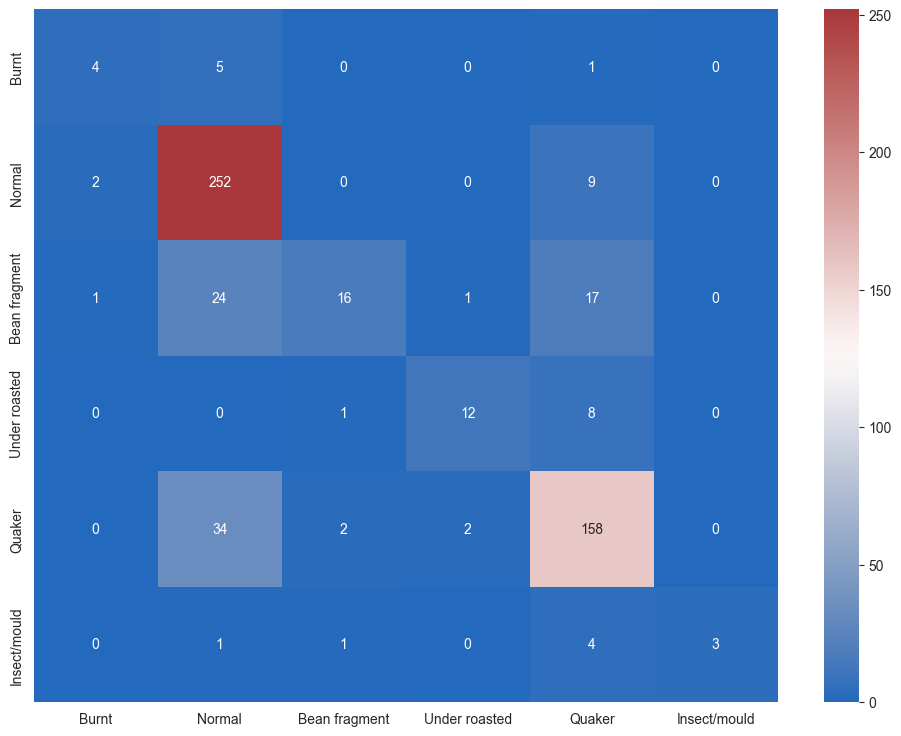

In [33]:
from torcheval.metrics import MulticlassConfusionMatrix
import seaborn as sns
import matplotlib.pyplot as plt

DEFECT_CLASSES_PRINT_NAMES = {
    "burnt": "Burnt",
    "normal": "Normal",
    "frag": "Bean fragment",
    "under": "Under roasted",
    "quaker": "Quaker",
    "insectOrMold": "Insect/mould",
}

X_train_hists = [
    histogram(img.numpy(), nbins=256, channel_axis=0)[0].ravel() for img in X_train
]
X_test_hists = [
    histogram(img.numpy(), nbins=256, channel_axis=0)[0].ravel() for img in X_test
]

knn = KNeighborsClassifier(n_neighbors=6, metric="canberra")
knn.fit(X_train_hists, y_train)
preds = knn.predict(X_test_hists)
print(
    classification_report(
        y_test, preds, zero_division=0, target_names=DEFECT_CLASSES.keys(), digits=3
    )
)

matrix = MulticlassConfusionMatrix(len(DEFECT_CLASSES))
matrix.update(torch.tensor(preds), y_test)

confs = matrix.compute()


fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    confs,
    annot=True,  # write values in cells
    cmap="vlag",
    xticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    yticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    ax=ax,
    fmt="g",  # annotate without using scientific notation
)
plt.savefig("../report/figures/confusionMatrices/KNN-2.png")

              precision    recall  f1-score   support

       burnt      1.000     0.100     0.182        10
      normal      0.803     0.962     0.875       263
        frag      0.667     0.136     0.225        59
       under      0.571     0.190     0.286        21
      quaker      0.735     0.837     0.783       196
insectOrMold      0.000     0.000     0.000         9

    accuracy                          0.771       558
   macro avg      0.629     0.371     0.392       558
weighted avg      0.747     0.771     0.725       558



<Axes: >

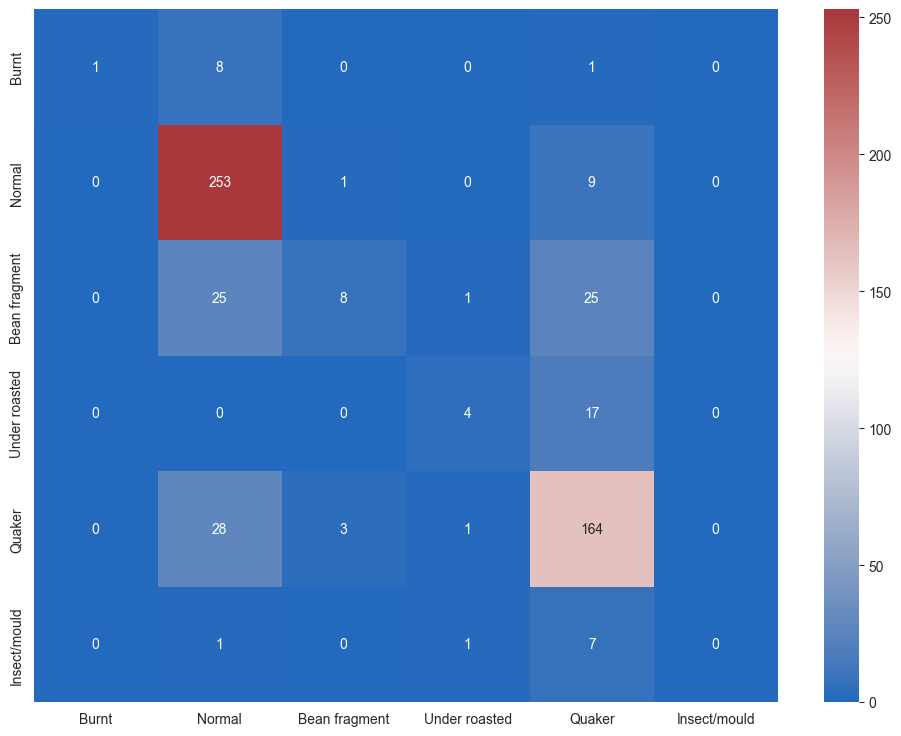

In [29]:
X_train_hists = [
    histogram(img.numpy(), nbins=32, channel_axis=0)[0].ravel() for img in X_train
]
X_test_hists = [
    histogram(img.numpy(), nbins=32, channel_axis=0)[0].ravel() for img in X_test
]

knn = KNeighborsClassifier(n_neighbors=11, metric="manhattan")
knn.fit(X_train_hists, y_train)
preds = knn.predict(X_test_hists)
print(
    classification_report(
        y_test, preds, zero_division=0, target_names=DEFECT_CLASSES.keys(), digits=3
    )
)

matrix = MulticlassConfusionMatrix(len(DEFECT_CLASSES))
matrix.update(torch.tensor(preds), y_test)

confs = matrix.compute()


fig, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(
    confs,
    annot=True,  # write values in cells
    cmap="vlag",
    xticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    yticklabels=[DEFECT_CLASSES_PRINT_NAMES[key] for key in DEFECT_CLASSES.keys()],
    ax=ax,
    fmt="g",  # annotate without using scientific notation
)